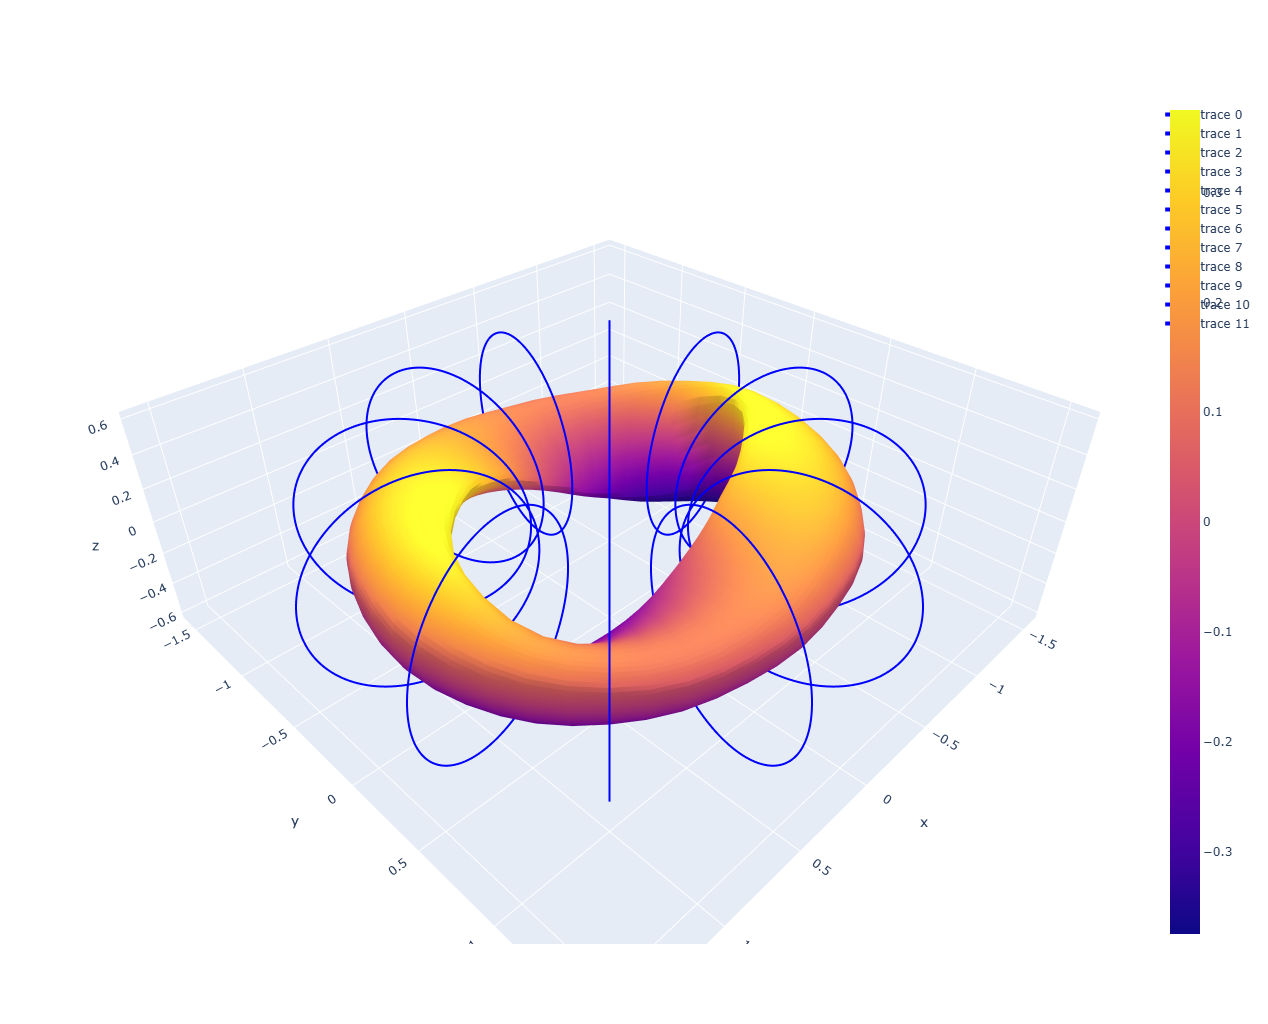

Initial max|B dot n|: 0.26125535217141904


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from simsopt._core import load
from simsopt.geo import plot, MeanSquaredCurvature, CurveSurfaceDistance, CurveCurveDistance, LpCurveCurvature
from simsopt.geo import SurfaceRZFourier, create_equally_spaced_curves, \
    CurveLength, curves_to_vtk, CurveCWSFourier, ArclengthVariation
from simsopt.field import Current, coils_via_symmetries, BiotSavart
from simsopt.objectives import SquaredFlux, QuadraticPenalty
from scipy.optimize import minimize

res = load(f'serial0021326.json')

MAXITER = 200
quadpoints = 300
USE_PRESIM = False
USE_CWS = True

major_R = 1
minor_r = 0.5 #parameter search
ncoils = 3
order = 3
nfp_coils = 1
current_0  = 1
current_mult = 1e5
FIX_ONE_CURRENT = True



nphi = 48
ntheta = 48
s = SurfaceRZFourier.from_vmec_input('input', range="full torus", nphi=nphi, ntheta=ntheta)

##creating coils and currents:
#if USE_PRESIM:
#    coils_presim = res[1]
#    surface = res[0][-1]
#    base_curves = [x.curve for x in coils_presim]
#    base_currents = [x.current for x in coils_presim]
#    base_currents[0].fix_all()
#else:
#    base_curves = create_equally_spaced_curves(ncoils, s.nfp, stellsym=True, R0=1, R1=0.6, order=order)
#    base_currents = [Current(current_0) for i in range(ncoils)]
#    if FIX_ONE_CURRENT:
#        base_currents[0].fix_all()

if USE_CWS:
    theta_linspace = np.linspace(0, 1, ntheta, endpoint=True)
    phi_linspace = np.linspace(0, 1, nphi, endpoint=True)
    # currently don't know what this does, most likely only extension away from plasma
    # this could be necessary if the CWS is more complicated and is generated from a stage I 
    # ext_via_normal_factor = 0.2565
    #ext_via_normal_factor = 0.1482   
    #cws.extend_via_normal(ext_via_normal_factor)
    #0.25216216216216214
    # CREATE COIL WINDING SURFACE SURFACE
    cws = SurfaceRZFourier(nfp=nfp_coils,stellsym=True)
    cws.set_rc(0,0,major_R)
    cws.set_rc(major_R,0,minor_r+0.1)
    cws.set_zs(major_R,0,minor_r+0.1)

    # CREATE CURVES + COILS     
    base_curves = []
    for i in range(ncoils):
        curve_cws = CurveCWSFourier(
            mpol=cws.mpol,
            ntor=cws.ntor,
            idofs=cws.x,
            quadpoints=quadpoints,
            order=order,
            nfp=nfp_coils,
            stellsym=cws.stellsym,
        )
        angle = (i + 0.5)*(2 * np.pi)/((2) * s.nfp * ncoils)
        curve_dofs = np.zeros(len(curve_cws.get_dofs()),)
        curve_dofs[0] = 1
        curve_dofs[2*order+2] = 0
        curve_dofs[2*order+3] = angle
        curve_cws.set_dofs(curve_dofs)
        curve_cws.fix(0)
        curve_cws.fix(2*order+2)
        base_curves.append(curve_cws)
    base_currents = [Current(current_0)*current_mult for i in range(ncoils)]
    if FIX_ONE_CURRENT:
        base_currents[0].fix_all()
   


coils = coils_via_symmetries(base_curves, base_currents, nfp_coils*2, True)
curves = [c.curve for c in coils]

fig = plot(coils + [s] , engine="plotly", close=True, show=False)
fig.update_layout(
    autosize=False,
    width=1024,
    height=1024,)
fig.show()

bs = BiotSavart(coils)
bs.set_points(s.gamma().reshape((-1, 3)))

B_dot_n = np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)
print('Initial max|B dot n|:', np.max(np.abs(B_dot_n)))


In [13]:
##calculating magnetic field from coils:

# another init values from repo
# LENGTH_THRESHOLD = 20
# LENGTH_WEIGHT = 1e-8
# CC_THRESHOLD = 0.1
# CC_WEIGHT = 100
# CURVATURE_THRESHOLD = 60
# CURVATURE_WEIGHT = 1e-5
# MSC_THRESHOLD = 20
# MSC_WEIGHT = 1e-9
# ARCLENGTH_WEIGHT = 3e-8
# LENGTH_CON_WEIGHT = 0.1
# MAXITER = 50


FLUX_WEIGHT = 3

##setting up parameters for penalty function:
# Threshold and weight for the maximum length of each individual coil:
#LENGTH_THRESHOLD = 20
#LENGTH_WEIGHT = 1e-8

LENGTH_THRESHOLD = 20  
LENGTH_WEIGHT = 1e-8


# Threshold and weight for the coil-to-coil distance penalty in the objective function:
#CC_THRESHOLD = 0.1
#CC_WEIGHT = 100

CC_THRESHOLD = 0.1
CC_WEIGHT = 300


# Threshold and weight for the curvature penalty in the objective function:
#CURVATURE_THRESHOLD = 60
#CURVATURE_WEIGHT = 1e-5

CURVATURE_THRESHOLD = 20
CURVATURE_WEIGHT = 1e-2


# Threshold and weight for the mean squared curvature penalty in the objective function:
#MSC_THRESHOLD = 60
#MSC_WEIGHT = 1e-9
#ARCLENGTH_WEIGHT = 3e-8
#LENGTH_CON_WEIGHT = 0.1

MSC_THRESHOLD = 60
MSC_WEIGHT = 1e-9
ARCLENGTH_WEIGHT = 3e-8
LENGTH_CON_WEIGHT = 0.1

LENGTH_THRESHOLD = 20
LENGTH_WEIGHT = 1e-8
CC_THRESHOLD = 0.1
CC_WEIGHT = 100
CURVATURE_THRESHOLD = 60
CURVATURE_WEIGHT = 1e-5
MSC_THRESHOLD = 20
MSC_WEIGHT = 1e-9
ARCLENGTH_WEIGHT = 3e-8
LENGTH_CON_WEIGHT = 0.1

Jf = FLUX_WEIGHT * SquaredFlux(s, bs, definition="local")
Jls = [CurveLength(c) for c in base_curves]
Jccdist = CurveCurveDistance(curves, CC_THRESHOLD, num_basecurves=len(curves))
Jcs = [LpCurveCurvature(c, 2, CURVATURE_THRESHOLD) for i, c in enumerate(base_curves)]
Jmscs = [MeanSquaredCurvature(c) for c in base_curves]
Jals = [ArclengthVariation(c) for c in base_curves]
J_LENGTH = LENGTH_WEIGHT * sum(Jls)
J_CC = CC_WEIGHT * Jccdist
J_CURVATURE = CURVATURE_WEIGHT * sum(Jcs)
J_MSC = MSC_WEIGHT * sum(QuadraticPenalty(J, MSC_THRESHOLD, f="max") for i, J in enumerate(Jmscs))
J_ALS = ARCLENGTH_WEIGHT * sum(Jals)
J_LENGTH_PENALTY = LENGTH_CON_WEIGHT * sum([QuadraticPenalty(Jls[i], LENGTH_THRESHOLD, f="max") for i in range(len(base_curves))])
JF = Jf + J_CC + J_LENGTH_PENALTY + J_CURVATURE + J_ALS + J_MSC + J_LENGTH


B_dot_n = np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)

print('Initial max|B dot n|:', np.max(np.abs(B_dot_n)))



def fun(dofs):
    JF.x = dofs
    J = JF.J()
    grad = JF.dJ()
    jf = Jf.J()
    BdotN = np.mean(np.abs(np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)))
    outstr = f"J={J:.3e}, Jf={jf:.3e}, ⟨B·n⟩={BdotN:.1e}"
    cl_string = ", ".join([f"{J.J():.1f}" for J in Jls])
    kap_string = ", ".join(f"{np.max(c.kappa()):.1f}" for c in base_curves)
    msc_string = ", ".join(f"{J.J():.1f}" for J in Jmscs)
    outstr += f", Len=sum([{cl_string}])={sum(J.J() for J in Jls):.1f}, ϰ=[{kap_string}], ∫ϰ²/L=[{msc_string}]"
    outstr += f", C-C-Sep={Jccdist.shortest_distance():.2f}"
    print(outstr)
    return J, grad
    

print("""
################################################################################
### Perform a Taylor test ######################################################
################################################################################
""")
f = fun
dofs = JF.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
for eps in [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    print("err", (J1-J2)/(2*eps) - dJh)

print("""
################################################################################
### Run the optimisation #######################################################
################################################################################
""")

B_dot_n = np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)
B_dot_n_max = np.max(np.abs(B_dot_n)).copy()

total_curve_length_start = sum(func.J() for func in Jls).copy()


res = minimize(fun, dofs, jac=True, method='L-BFGS-B',
               options={'maxiter': MAXITER, 'maxcor': 500, 'iprint': 5}, tol=1e-10)

B_dot_n = np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)
print('starting max|B dot n|:', B_dot_n_max)
print('Final max|B dot n|:', np.max(np.abs(B_dot_n)))
total_curve_length = sum(func.J() for func in Jls)
print("starting Sum of lengths of base curves:", total_curve_length_start)
print("Sum of lengths of base curves:", total_curve_length)

Initial max|B dot n|: 0.26125535217141904

################################################################################
### Perform a Taylor test ######################################################
################################################################################

J=7.780e-01, Jf=7.780e-01, ⟨B·n⟩=4.7e-02, Len=sum([3.8, 3.8, 3.8])=11.3, ϰ=[1.7, 1.7, 1.7], ∫ϰ²/L=[2.8, 2.8, 2.8], C-C-Sep=0.21
J=7.781e-01, Jf=7.781e-01, ⟨B·n⟩=4.7e-02, Len=sum([3.8, 3.8, 3.8])=11.3, ϰ=[1.7, 1.7, 1.7], ∫ϰ²/L=[2.8, 2.8, 2.8], C-C-Sep=0.21
J=7.780e-01, Jf=7.780e-01, ⟨B·n⟩=4.7e-02, Len=sum([3.8, 3.8, 3.8])=11.3, ϰ=[1.7, 1.7, 1.7], ∫ϰ²/L=[2.8, 2.8, 2.8], C-C-Sep=0.21
err 6.332439095840803e-06
J=7.780e-01, Jf=7.780e-01, ⟨B·n⟩=4.7e-02, Len=sum([3.8, 3.8, 3.8])=11.3, ϰ=[1.7, 1.7, 1.7], ∫ϰ²/L=[2.8, 2.8, 2.8], C-C-Sep=0.21
J=7.780e-01, Jf=7.780e-01, ⟨B·n⟩=4.7e-02, Len=sum([3.8, 3.8, 3.8])=11.3, ϰ=[1.7, 1.7, 1.7], ∫ϰ²/L=[2.8, 2.8, 2.8], C-C-Sep=0.21
err 6.337493915764547e-08
J=7.780e-01, Jf=7.780

 This problem is unconstrained.


J=9.914e-01, Jf=7.666e-01, ⟨B·n⟩=4.7e-02, Len=sum([5.0, 4.8, 4.9])=14.7, ϰ=[8.3, 7.5, 5.3], ∫ϰ²/L=[6.2, 6.9, 5.7], C-C-Sep=0.00
J=3.864e-01, Jf=3.864e-01, ⟨B·n⟩=3.3e-02, Len=sum([4.1, 4.0, 4.1])=12.2, ϰ=[4.2, 3.8, 3.0], ∫ϰ²/L=[4.3, 4.3, 3.8], C-C-Sep=0.13
J=2.743e-01, Jf=2.694e-01, ⟨B·n⟩=2.5e-02, Len=sum([4.2, 4.4, 4.2])=12.9, ϰ=[5.1, 6.1, 4.1], ∫ϰ²/L=[4.7, 5.9, 4.8], C-C-Sep=0.07
J=2.971e-01, Jf=2.319e-01, ⟨B·n⟩=2.2e-02, Len=sum([4.2, 4.6, 4.5])=13.3, ϰ=[4.6, 7.6, 6.3], ∫ϰ²/L=[4.5, 6.5, 5.9], C-C-Sep=0.03
J=2.557e-01, Jf=2.432e-01, ⟨B·n⟩=2.3e-02, Len=sum([4.2, 4.5, 4.3])=13.0, ϰ=[4.9, 6.7, 4.9], ∫ϰ²/L=[4.6, 6.2, 5.2], C-C-Sep=0.06
J=2.410e-01, Jf=2.355e-01, ⟨B·n⟩=2.2e-02, Len=sum([4.1, 4.5, 4.4])=13.0, ϰ=[4.2, 6.8, 5.6], ∫ϰ²/L=[4.3, 6.1, 5.5], C-C-Sep=0.07
J=2.305e-01, Jf=2.247e-01, ⟨B·n⟩=2.1e-02, Len=sum([4.2, 4.4, 4.4])=13.0, ϰ=[4.2, 6.8, 6.3], ∫ϰ²/L=[4.3, 6.0, 5.9], C-C-Sep=0.07

At iterate    5    f=  2.30495D-01    |proj g|=  1.61884D-01
J=2.190e-01, Jf=1.931e-01, ⟨B·n⟩=2.0e-02, 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=1.157e-01, Jf=1.084e-01, ⟨B·n⟩=1.6e-02, Len=sum([4.6, 4.9, 6.1])=15.6, ϰ=[105.0, 74.0, 228.5], ∫ϰ²/L=[32.1, 34.8, 75.1], C-C-Sep=0.07
J=1.134e-01, Jf=1.084e-01, ⟨B·n⟩=1.6e-02, Len=sum([4.6, 4.9, 6.1])=15.6, ϰ=[121.5, 74.1, 211.8], ∫ϰ²/L=[36.1, 34.8, 71.4], C-C-Sep=0.08

At iterate   25    f=  1.13391D-01    |proj g|=  7.88484D-02
J=1.126e-01, Jf=1.086e-01, ⟨B·n⟩=1.6e-02, Len=sum([4.6, 4.9, 6.1])=15.6, ϰ=[139.0, 72.1, 193.7], ∫ϰ²/L=[41.0, 34.5, 67.5], C-C-Sep=0.08
J=1.117e-01, Jf=1.084e-01, ⟨B·n⟩=1.6e-02, Len=sum([4.6, 4.9, 6.1])=15.6, ϰ=[165.1, 68.2, 177.0], ∫ϰ²/L=[48.3, 34.0, 64.2], C-C-Sep=0.08
J=1.104e-01, Jf=1.064e-01, ⟨B·n⟩=1.6e-02, Len=sum([4.7, 4.9, 6.0])=15.6, ϰ=[223.0, 66.8, 143.6], ∫ϰ²/L=[65.3, 34.3, 60.1], C-C-Sep=0.08
J=1.194e-01, Jf=1.031e-01, ⟨B·n⟩=1.5e-02, Len=sum([4.8, 4.9, 5.9])=15.7, ϰ=[495.7, 80.6, 105.0], ∫ϰ²/L=[147.1, 39.3, 49.8], C-C-Sep=0.07
J=1.103e-01, Jf=1.055e-01, ⟨B·n⟩=1.6e-02, Len=sum([4.7, 4.9, 6.0])=15.6, ϰ=[249.9, 67.3, 143.6], ∫ϰ²/L=[70.7, 34.8, 58.5]


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=2.342e-01, Jf=9.366e-02, ⟨B·n⟩=1.4e-02, Len=sum([4.8, 4.9, 5.8])=15.5, ϰ=[83.2, 207.7, 89.3], ∫ϰ²/L=[26.1, 71.8, 42.4], C-C-Sep=0.00
J=1.073e-01, Jf=9.810e-02, ⟨B·n⟩=1.5e-02, Len=sum([4.9, 4.9, 5.8])=15.6, ϰ=[284.6, 111.4, 88.3], ∫ϰ²/L=[80.4, 47.8, 44.9], C-C-Sep=0.07
J=1.056e-01, Jf=9.507e-02, ⟨B·n⟩=1.5e-02, Len=sum([4.9, 4.9, 5.8])=15.6, ϰ=[210.5, 142.2, 86.8], ∫ϰ²/L=[59.2, 55.3, 43.9], C-C-Sep=0.07

At iterate   45    f=  1.05580D-01    |proj g|=  3.77965D-01
J=1.027e-01, Jf=9.420e-02, ⟨B·n⟩=1.5e-02, Len=sum([4.9, 4.9, 5.8])=15.6, ϰ=[203.4, 156.6, 88.2], ∫ϰ²/L=[57.3, 58.2, 43.6], C-C-Sep=0.08
J=1.017e-01, Jf=9.268e-02, ⟨B·n⟩=1.5e-02, Len=sum([4.9, 4.9, 5.8])=15.6, ϰ=[180.1, 182.4, 89.5], ∫ϰ²/L=[51.7, 63.7, 42.9], C-C-Sep=0.08
J=1.011e-01, Jf=9.204e-02, ⟨B·n⟩=1.4e-02, Len=sum([4.9, 4.9, 5.8])=15.6, ϰ=[167.7, 182.1, 89.4], ∫ϰ²/L=[49.6, 63.7, 42.4], C-C-Sep=0.08
J=9.965e-02, Jf=9.142e-02, ⟨B·n⟩=1.4e-02, Len=sum([4.9, 4.9, 5.8])=15.6, ϰ=[165.1, 171.0, 84.9], ∫ϰ²/L=[47.4, 60.9, 40.0], 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=9.815e-02, Jf=9.263e-02, ⟨B·n⟩=1.5e-02, Len=sum([5.0, 4.9, 5.7])=15.6, ϰ=[167.7, 124.4, 75.3], ∫ϰ²/L=[48.0, 50.7, 36.3], C-C-Sep=0.08
J=9.779e-02, Jf=9.217e-02, ⟨B·n⟩=1.5e-02, Len=sum([5.0, 4.9, 5.7])=15.6, ϰ=[165.0, 125.3, 74.5], ∫ϰ²/L=[47.2, 50.6, 36.2], C-C-Sep=0.08
J=9.714e-02, Jf=9.134e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.0, 4.9, 5.7])=15.6, ϰ=[154.3, 117.2, 72.7], ∫ϰ²/L=[45.3, 48.0, 36.3], C-C-Sep=0.08

At iterate   55    f=  9.71437D-02    |proj g|=  1.33596D-01
J=9.826e-02, Jf=9.146e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.0, 4.9, 5.7])=15.7, ϰ=[129.5, 105.4, 71.3], ∫ϰ²/L=[38.6, 44.5, 36.7], C-C-Sep=0.08
J=9.686e-02, Jf=9.114e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.0, 4.9, 5.7])=15.6, ϰ=[141.5, 113.8, 71.6], ∫ϰ²/L=[43.1, 47.0, 36.4], C-C-Sep=0.08
J=1.045e-01, Jf=9.417e-02, ⟨B·n⟩=1.5e-02, Len=sum([5.1, 5.0, 5.7])=15.7, ϰ=[113.0, 72.3, 74.1], ∫ϰ²/L=[36.1, 37.8, 37.5], C-C-Sep=0.07
J=9.670e-02, Jf=9.115e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.0, 4.9, 5.7])=15.7, ϰ=[140.2, 103.8, 70.8], ∫ϰ²/L=[41.1, 44.4, 36.6], 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=5.227e-01, Jf=1.254e-01, ⟨B·n⟩=1.8e-02, Len=sum([5.1, 4.9, 5.8])=15.8, ϰ=[70.6, 85.6, 158.1], ∫ϰ²/L=[26.2, 35.8, 54.2], C-C-Sep=0.00
J=9.580e-02, Jf=9.141e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5.7])=15.7, ϰ=[113.7, 80.9, 75.9], ∫ϰ²/L=[35.0, 38.7, 38.2], C-C-Sep=0.08

At iterate   75    f=  9.57960D-02    |proj g|=  1.00543D-01
J=9.554e-02, Jf=9.126e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5.7])=15.7, ϰ=[107.9, 80.2, 79.0], ∫ϰ²/L=[33.7, 38.6, 38.5], C-C-Sep=0.08
J=9.560e-02, Jf=9.085e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5.7])=15.7, ϰ=[94.9, 85.0, 83.4], ∫ϰ²/L=[31.3, 38.9, 39.0], C-C-Sep=0.08
J=9.548e-02, Jf=9.112e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5.7])=15.7, ϰ=[104.9, 81.3, 80.1], ∫ϰ²/L=[33.1, 38.6, 38.6], C-C-Sep=0.08
J=9.551e-02, Jf=9.091e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5.7])=15.7, ϰ=[98.2, 83.8, 82.3], ∫ϰ²/L=[31.9, 38.8, 38.8], C-C-Sep=0.08
J=9.890e-02, Jf=9.207e-02, ⟨B·n⟩=1.5e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[83.7, 100.8, 90.0], ∫ϰ²/L=[27.9, 39.4, 40.6], C-C-Sep=


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=9.544e-02, Jf=9.056e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5.7])=15.7, ϰ=[97.0, 90.4, 81.1], ∫ϰ²/L=[31.7, 39.5, 38.7], C-C-Sep=0.08
J=9.561e-02, Jf=9.051e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5.7])=15.7, ϰ=[98.5, 90.7, 80.9], ∫ϰ²/L=[31.7, 39.5, 38.7], C-C-Sep=0.08
J=9.545e-02, Jf=9.055e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5.7])=15.7, ϰ=[97.3, 90.5, 81.0], ∫ϰ²/L=[31.7, 39.5, 38.7], C-C-Sep=0.08
J=9.544e-02, Jf=9.056e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5.7])=15.7, ϰ=[97.1, 90.5, 81.0], ∫ϰ²/L=[31.7, 39.5, 38.7], C-C-Sep=0.08
J=9.544e-02, Jf=9.056e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5.7])=15.7, ϰ=[97.0, 90.4, 81.0], ∫ϰ²/L=[31.7, 39.5, 38.7], C-C-Sep=0.08
J=9.544e-02, Jf=9.056e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5.7])=15.7, ϰ=[97.0, 90.4, 81.0], ∫ϰ²/L=[31.7, 39.5, 38.7], C-C-Sep=0.08
J=9.544e-02, Jf=9.056e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5.7])=15.7, ϰ=[97.0, 90.4, 81.1], ∫ϰ²/L=[31.7, 39.5, 38.7], C-C-Sep=0.08
J=9.544e-02, Jf=9.056e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=4.580e-01, Jf=1.083e-01, ⟨B·n⟩=1.5e-02, Len=sum([5.4, 5.0, 5.7])=16.2, ϰ=[135.6, 107.2, 127.4], ∫ϰ²/L=[41.8, 43.9, 49.3], C-C-Sep=0.00
J=9.535e-02, Jf=9.064e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5.7])=15.7, ϰ=[97.8, 87.7, 81.7], ∫ϰ²/L=[31.7, 39.2, 38.8], C-C-Sep=0.08

At iterate   80    f=  9.53522D-02    |proj g|=  7.90045D-02
J=9.537e-02, Jf=9.072e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5.7])=15.7, ϰ=[99.6, 84.1, 82.7], ∫ϰ²/L=[31.9, 38.7, 39.0], C-C-Sep=0.08
J=9.534e-02, Jf=9.066e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5.7])=15.7, ϰ=[98.2, 86.9, 81.9], ∫ϰ²/L=[31.8, 39.1, 38.8], C-C-Sep=0.08
J=9.535e-02, Jf=9.070e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5.7])=15.7, ϰ=[99.1, 85.1, 82.4], ∫ϰ²/L=[31.9, 38.9, 38.9], C-C-Sep=0.08
J=9.651e-02, Jf=9.105e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.8, ϰ=[100.5, 75.2, 87.2], ∫ϰ²/L=[32.9, 37.1, 39.9], C-C-Sep=0.08
J=9.538e-02, Jf=9.075e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.1, 4.9, 5.7])=15.7, ϰ=[100.7, 82.2, 83.3], ∫ϰ²/L=[32.0, 38.5, 39.1], C-C-Sep=


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=1.021e-01, Jf=9.011e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[99.9, 93.6, 82.0], ∫ϰ²/L=[32.2, 39.5, 39.0], C-C-Sep=0.07
J=9.509e-02, Jf=9.062e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[101.0, 82.9, 83.9], ∫ϰ²/L=[32.1, 38.3, 39.3], C-C-Sep=0.08
J=9.515e-02, Jf=9.052e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[100.1, 83.9, 83.7], ∫ϰ²/L=[32.0, 38.4, 39.3], C-C-Sep=0.08
J=9.510e-02, Jf=9.060e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[100.8, 83.1, 83.8], ∫ϰ²/L=[32.1, 38.3, 39.3], C-C-Sep=0.08
J=9.509e-02, Jf=9.062e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[101.0, 82.9, 83.9], ∫ϰ²/L=[32.1, 38.3, 39.3], C-C-Sep=0.08
J=9.509e-02, Jf=9.061e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[100.9, 83.0, 83.9], ∫ϰ²/L=[32.1, 38.3, 39.3], C-C-Sep=0.08
J=9.509e-02, Jf=9.061e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[100.9, 82.9, 83.9], ∫ϰ²/L=[32.1, 38.3, 39.3], C-C-Sep=0.08
J=9.509e-02, Jf=9.062e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=2.451e-01, Jf=9.455e-02, ⟨B·n⟩=1.5e-02, Len=sum([5.4, 4.9, 5.7])=15.9, ϰ=[83.4, 59.4, 100.2], ∫ϰ²/L=[30.3, 34.1, 43.4], C-C-Sep=0.00
J=9.531e-02, Jf=9.053e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[96.1, 82.0, 84.9], ∫ϰ²/L=[31.5, 37.9, 39.5], C-C-Sep=0.08
J=9.509e-02, Jf=9.054e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[98.6, 82.9, 84.4], ∫ϰ²/L=[31.8, 38.1, 39.4], C-C-Sep=0.08
J=9.509e-02, Jf=9.054e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[99.0, 83.0, 84.3], ∫ϰ²/L=[31.9, 38.1, 39.4], C-C-Sep=0.08
J=9.509e-02, Jf=9.054e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[98.7, 82.9, 84.3], ∫ϰ²/L=[31.8, 38.1, 39.4], C-C-Sep=0.08
J=9.509e-02, Jf=9.054e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[98.6, 82.9, 84.4], ∫ϰ²/L=[31.8, 38.1, 39.4], C-C-Sep=0.08
J=9.509e-02, Jf=9.054e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[98.7, 82.9, 84.3], ∫ϰ²/L=[31.8, 38.1, 39.4], C-C-Sep=0.08
J=9.509e-02, Jf=9.054e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=9.511e-02, Jf=9.052e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[97.3, 82.6, 84.7], ∫ϰ²/L=[31.7, 38.0, 39.5], C-C-Sep=0.08
J=9.509e-02, Jf=9.053e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[98.4, 82.8, 84.4], ∫ϰ²/L=[31.8, 38.1, 39.4], C-C-Sep=0.08
J=9.509e-02, Jf=9.054e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[98.7, 82.9, 84.4], ∫ϰ²/L=[31.8, 38.1, 39.4], C-C-Sep=0.08
J=9.509e-02, Jf=9.054e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[98.7, 82.9, 84.3], ∫ϰ²/L=[31.8, 38.1, 39.4], C-C-Sep=0.08
J=9.509e-02, Jf=9.054e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[98.7, 82.9, 84.3], ∫ϰ²/L=[31.8, 38.1, 39.4], C-C-Sep=0.08
J=9.509e-02, Jf=9.054e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[98.7, 82.9, 84.3], ∫ϰ²/L=[31.8, 38.1, 39.4], C-C-Sep=0.08
J=9.509e-02, Jf=9.054e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5.7])=15.7, ϰ=[98.7, 82.9, 84.3], ∫ϰ²/L=[31.8, 38.1, 39.4], C-C-Sep=0.08
J=9.509e-02, Jf=9.054e-02, ⟨B·n⟩=1.4e-02, Len=sum([5.2, 4.9, 5


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [14]:
from simsopt._core import save

save(bs,'3_bs_opt.json')
save(bs.coils,'3_coils_opt.json')

In [18]:
#fig = plot(coils + [s] + [cws], engine="plotly", close=True, show=False)
fig = plot(coils + [s] , engine="plotly", close=True, show=False)
fig.update_layout(
    autosize=False,
    width=1024,
    height=1024,)
fig.show()

In [16]:
from simsopt.field.magneticfieldclasses import InterpolatedField
import os

def make_Bnormal_plots(bs, s_plot, out_dir='', bs_filename="Bnormal"):
    """
    Plot Bnormal on plasma surface from a MagneticField object.
    Do this quite a bit in the permanent magnet optimization
    and initialization so this is a wrapper function to reduce
    the amount of code.

    Args:
        bs: MagneticField class object.
        s_plot: plasma boundary surface with range = 'full torus'.
        out_dir: Path or string for the output directory for saved files.
        bs_filename: String denoting the name of the output file. 
    """
    nphi = len(s_plot.quadpoints_phi)
    ntheta = len(s_plot.quadpoints_theta)
    bs.set_points(s_plot.gamma().reshape((-1, 3)))
    pointData = {"B_N": np.sum(bs.B().reshape((nphi, ntheta, 3)) * s_plot.unitnormal(), axis=2)[:, :, None]}
    s_plot.to_vtk(out_dir + bs_filename, extra_data=pointData)

def trace_fieldlines(bfield, label, s, out_dir=''):
    """
    Make Poincare plots on a surface as in the trace_fieldlines
    example in the examples/1_Simple/ directory.

    Args:
        bfield: MagneticField or InterpolatedField class object.
        label: Name of the file to write to.
        s: plasma boundary surface.
        out_dir: Path or string for the output directory for saved files.
    """
    from simsopt.field.tracing import compute_fieldlines, \
        plot_poincare_data, \
        IterationStoppingCriterion,LevelsetStoppingCriterion, SurfaceClassifier

    # set fieldline tracer parameters
    nfieldlines = 32
    tmax_fl = 2500
    nplanes = 4

    Z0 = np.zeros(nfieldlines)
    #R0 = np.linspace(s.get_rc(0, 0), s.get_rc(0, 0) + s.get_rc(1, 0) / 4.0, nfieldlines)
    #R0 = np.linspace(s.get_rc(0, 0), s.get_rc(0, 0) + s.get_rc(1, 0) / 2.0, nfieldlines)
    R0 = np.linspace(0.9, 1.4, nfieldlines)
    #Z0 = np.zeros(nfieldlines)
    phis = [(i / 4) * (2 * np.pi / s.nfp) for i in range(nplanes)]

    print("Compute the fieldlines from the initial locations")
    sc_fieldline = SurfaceClassifier(s, h=0.03, p=2)
    #sc_fieldline.to_vtk(str(out_dir) + 'levelset', h=0.02)

    stopping_crit = [LevelsetStoppingCriterion(sc_fieldline.dist)]

    fieldlines_tys, fieldlines_phi_hits = compute_fieldlines(
        bfield, R0, Z0, tmax=tmax_fl, tol=1e-8,
        phis=phis,
        stopping_criteria=stopping_crit)

    print("Plotting")
    plot_poincare_data(fieldlines_phi_hits, phis, out_dir + label + '.png', dpi=100, surf=s)


# Directory for output
OUT_DIR = "./poincare/"
os.makedirs(OUT_DIR, exist_ok=True)

# calculating magnetic field from coils:
bs = BiotSavart(coils)


n = 64
rs = np.linalg.norm(s.gamma()[:, :, 0:2], axis=2)
zs = s.gamma()[:, :, 2]
r_margin = 0.05
rrange = (np.min(rs) - r_margin, np.max(rs) + r_margin, n)
phirange = (0, 2 * np.pi / s.nfp, n * 2)
zrange = (0, np.max(zs), n // 2)
degree = 4  # 2 is sufficient sometimes
nphi = len(s.quadpoints_phi)
ntheta = len(s.quadpoints_theta)
bs.set_points(s.gamma().reshape((-1, 3)))
Bnormal = np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)
make_Bnormal_plots(bs, s, OUT_DIR, "3_biot_savart_pre_poincare_check")

print("Interpolating Field")
bsh = InterpolatedField(
    bs , degree, rrange, phirange, zrange, True, nfp=s.nfp, stellsym=s.stellsym
)
bsh.set_points(s.gamma().reshape((-1, 3)))

bsh.to_vtk('poincare/3_CWS_bsh')
trace_fieldlines(bsh, 'poincare_3_CWS', s, OUT_DIR)

Interpolating Field
Compute the fieldlines from the initial locations
Plotting


<Figure size 640x480 with 0 Axes>